# 1-Train and classify for linearly separable case and kernals

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.io import loadmat
#Importing with custom names to avoid issues with numpy / sympy matrix


from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.model_selection import train_test_split




In [5]:
data=loadmat("ex.mat")

In [6]:
#print(data)


In [7]:
y=data['y']
x=data['X']

In [8]:
#print(x)
#print(y)
print(x.shape)
print(y.shape)

(51, 2)
(51, 1)


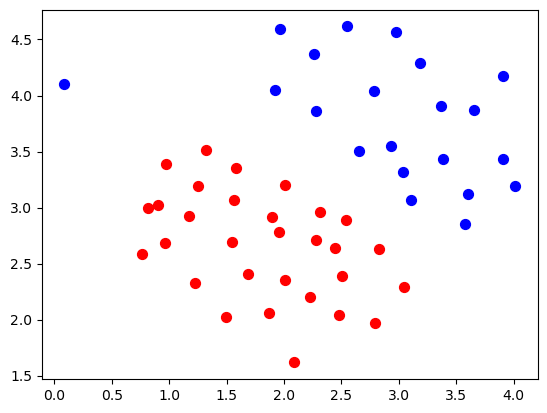

In [9]:

for i in range(len(x)):
    if y[i]==0:
        plt.scatter(x[i][0],x[i][1],s=50,c='r')
    else:
         plt.scatter(x[i][0],x[i][1],s=50,c='b')

In [10]:
    #we first insert out data into a pandes datafream
    #to make it easer for us to normalized it

    x_train=pd.DataFrame(x)


In [11]:
#define normalization function
def fnorm(x):
    new=x-np.mean(x,axis=0)
    return new/np.std(new,axis=0)

In [12]:
#normalize data using defined function
x_train=fnorm(x_train)

In [13]:
#calc means and vars
means=[]
for i in x_train:
    means.append(np.mean(x_train[i],axis=0))
    
var=[]
for i in x_train:
    var.append(np.var(x_train[i],axis=0))
    

print("means of our tow features:",means)
print("variance of our tow features:",var)
    

    

means of our tow features: [-2.0898315757650005e-16, 1.9156789444512506e-16]
variance of our tow features: [1.0000000000000002, 1.0]


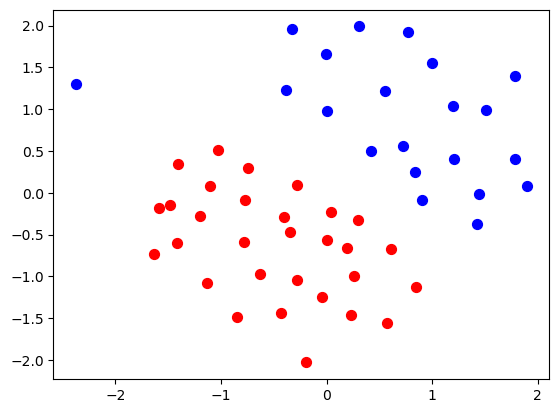

In [14]:
x_train=x_train.to_numpy()
#plot the data
for i in range(len(x_train)):
    if y[i]==0:
        plt.scatter(x_train[i][0],x_train[i][1],s=50,c='r')
    else:
         plt.scatter(x_train[i][0],x_train[i][1],s=50,c='b')

In [16]:
# split X and y into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
# check the shape of X_train and X_test

x_train.shape, x_test.shape

((40, 2), (11, 2))

In [17]:
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(x_train,y_train.ravel())
# make predictions on test set
y_pred=svc.predict(x_test)
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 1.0000


# Building the Hard Margin SVM

In [114]:
#########hard margin from scratch
y_train=np.ravel(y)
#insert high value for c,use a linear kernal
model=SVC(C=10,kernel="linear",gamma="auto")
model.fit(x_train,y_train)


SVC(C=10, gamma='auto', kernel='linear')

# calc genrlization error

In [132]:
search=GridSearchCV(estimator=model,param_grid=params_dict,cv=5)
search.fit(x_train,y_train)

#need the best pair of valus for c and gamme to use on our training data
best_svm=search.best_estimator_
best_svm.fit(x_train,y_train)
print(search.best_params_)

{'C': 0.1, 'gamma': 'auto'}


In [133]:
print("accurecy ",search.best_score_*100,"%")
print("genrlization error:  ",(1-search.best_score_)*100,"%")


accurecy  98.00000000000001 %
genrlization error:   1.9999999999999907 %


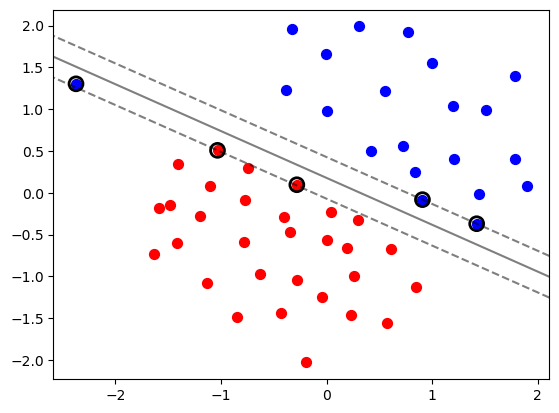

In [117]:
#creating our scatter plot 
for i in range(len(x_train)):
    if y[i]==0:
        plt.scatter(x_train[i][0],x_train[i][1],s=50,c='r')
    else:
         plt.scatter(x_train[i][0],x_train[i][1],s=50,c='b')
            
            
ax=plt.gca()
xlim=ax.get_xlim()
ylim=ax.get_ylim()

#creat grid to evalute model 
xx=np.linspace(xlim[0],xlim[1],30) 
yy=np.linspace(ylim[0],ylim[1],30) 
yy,xx=np.meshgrid(yy,xx)
xy=np.vstack([xx.ravel(),yy.ravel()]).T
z=model.decision_function(xy).reshape(xx.shape)


##plot decision boundary and margins

ax.contour(xx,yy,z,colors="k",levels=[-1,0,1],alpha=0.5,linestyles=["--","-","--"])

##plot support vectors
ax.scatter(
    model.support_vectors_[:,0],
    model.support_vectors_[:,1],
    s=100,
    linewidth=2,
    facecolors="none",
    edgecolors="black",)

plt.show()

            
            

In [118]:
#Free Support Vectors: Free support vectors lie on the margin.
#Bounded Support Vectors: All wrongly classified data points as well as the data points
   #that are correctly classified but are inside the margin area are bounded support vectors.

In [119]:
#to find the distance for all our points in x_train to our decition boudary
dists=model.decision_function(x_train)

# then find the absolte distance and round it down to 3 decimals
absdists=np.abs(dists)
absdists=[round(i,3)for i in absdists]

#count the number of free and bounded support vectors

Bounded=sum(i<1 for i in absdists )
Free=sum(i==1 for i in absdists)

print ("number of bounded:",Bounded,"\nNumber of free : ",Free)


number of bounded: 3 
Number of free :  2


# culc alpha and W,b in hard margin

In [120]:
#Initializing values and computing H. Note the 1. to force to float type
m,n = x.shape
y = y.reshape(-1,1) * 1.
X_dash = y * x
H = np.dot(X_dash , X_dash.T) * 1.



In [121]:
#Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) )))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

In [122]:
#Setting solver parameters (change default to decrease tolerance) 
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

In [123]:
#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])


In [124]:
#w parameter in vectorized form
w = ((y * alphas).T @ x).reshape(-1,1)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b
b = y[S] - np.dot(x[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

Alphas =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
w =  [ 6.13377760e-27 -1.02339798e-28]
b =  [-9.37291122e-27]


# build a Soft Margin SVM

In [125]:
#it is alogarithmeic scale
params_dict={"C":[0.001,0.01,0.1,1,10,100],"gamma":['auto']}
model=SVC(kernel="linear")

#use grid-seach to find the best pair of estimators on our trinaing data
#use 5-fold cross valisation in the grid search
search=GridSearchCV(estimator=model,param_grid=params_dict,cv=5)
search.fit(x_train,y_train)

#need the best pair of valus for c and gamme to use on our training data
best_svm=search.best_estimator_
best_svm.fit(x_train,y_train)
print(search.best_params_)




{'C': 0.1, 'gamma': 'auto'}


# Calc genrlization error

In [126]:

print("accurecy ",search.best_score_*100,"%")
print("genrlization error:  ",(1-search.best_score_)*100,"%")


accurecy  98.00000000000001 %
genrlization error:   1.9999999999999907 %


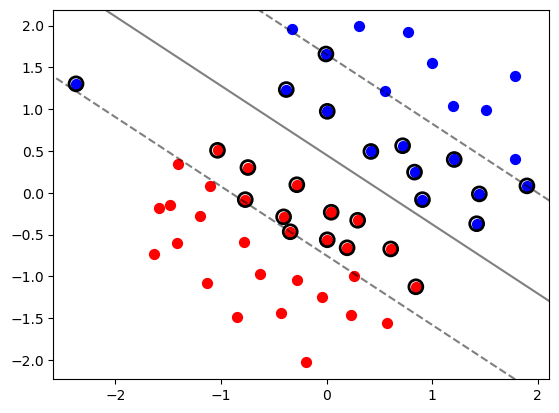

In [127]:
#creating our scatter plot 
for i in range(len(x_train)):
    if y[i]==0:
        plt.scatter(x_train[i][0],x_train[i][1],s=50,c='r')
    else:
         plt.scatter(x_train[i][0],x_train[i][1],s=50,c='b')
            
            
ax=plt.gca()
xlim=ax.get_xlim()
ylim=ax.get_ylim()

#creat grid to evalute model 
xx=np.linspace(xlim[0],xlim[1],30) 
yy=np.linspace(ylim[0],ylim[1],30) 
yy,xx=np.meshgrid(yy,xx)
xy=np.vstack([xx.ravel(),yy.ravel()]).T
z=best_svm.decision_function(xy).reshape(xx.shape)


##plot decision boundary and margins

ax.contour(xx,yy,z,colors="k",levels=[-1,0,1],alpha=0.5,linestyles=["--","-","--"])

##plot support vectors
ax.scatter(
    best_svm.support_vectors_[:,0],
    best_svm.support_vectors_[:,1],
    s=100,
    linewidth=2,
    facecolors="none",
    edgecolors="black",)

plt.show()

       

In [128]:
#to find the distance for all our points in x_train to our decition boudary
dists=best_svm.decision_function(x_train)

# then find the absolte distance and round it down to 3 decimals
absdists=np.abs(dists)
absdists=[round(i,3)for i in absdists]

#count the number of free and bounded support vectors

Bounded=sum(i<1 for i in absdists )
Free=sum(i==1 for i in absdists)

print ("number of bounded:",Bounded,"\nNumber of free : ",Free)


number of bounded: 21 
Number of free :  3


In [129]:
print(x)

[[1.9643   4.5957  ]
 [2.2753   3.8589  ]
 [2.9781   4.5651  ]
 [2.932    3.5519  ]
 [3.5772   2.856   ]
 [4.015    3.1937  ]
 [3.3814   3.4291  ]
 [3.9113   4.1761  ]
 [2.7822   4.0431  ]
 [2.5518   4.6162  ]
 [3.3698   3.9101  ]
 [3.1048   3.0709  ]
 [1.9182   4.0534  ]
 [2.2638   4.3706  ]
 [2.6555   3.5008  ]
 [3.1855   4.2888  ]
 [3.6579   3.8692  ]
 [3.9113   3.4291  ]
 [3.6002   3.1221  ]
 [3.0357   3.3165  ]
 [1.5841   3.3575  ]
 [2.0103   3.2039  ]
 [1.9527   2.7843  ]
 [2.2753   2.7127  ]
 [2.3099   2.9584  ]
 [2.8283   2.6309  ]
 [3.0473   2.2931  ]
 [2.4827   2.0373  ]
 [2.5057   2.3853  ]
 [1.8721   2.0577  ]
 [2.0103   2.3546  ]
 [1.2269   2.3239  ]
 [1.8951   2.9174  ]
 [1.561    3.0709  ]
 [1.5495   2.6923  ]
 [1.6878   2.4057  ]
 [1.4919   2.0271  ]
 [0.962    2.682   ]
 [1.1693   2.9276  ]
 [0.8122   2.9992  ]
 [0.9735   3.3881  ]
 [1.25     3.1937  ]
 [1.3191   3.5109  ]
 [2.2292   2.201   ]
 [2.4482   2.6411  ]
 [2.7938   1.9656  ]
 [2.091    1.6177  ]
 [2.5403   2.

# caclute alphas,w and b  in soft margin


In [130]:


#Initializing values and computing H. Note the 1. to force to float type
C = 20
m,n = x.shape
y = y.reshape(-1,1) * 1.
X_dash = y * x
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format - as previously
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])



In [131]:
#==================Computing and printing parameters===============================#
w = ((y * alphas).T @ x).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(x[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])


Alphas =  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
w =  [ 3.48823117e-26 -1.42732140e-26]
b =  [-7.33475379e-27]
